## To do
Write to dos here

In [1]:
import os
import sys

import numpy as np
import osmnx as ox
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

from pems_util import *
from shapely import geometry
from keplergl import KeplerGl

pd.set_option('display.max_columns', None)

In [2]:
# --- Global variables

# Setting up the Coordinate Reference Systems up front in the necessary format.
crs_degree = {'init': 'epsg:4326'} # CGS_WGS_1984 (what the GPS uses)

# --- Paths

# Root path of Fremont Dropbox

# We let this notebook to know where to look for fremontdropbox module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from fremontdropbox import get_dropbox_location
# Root path of the Dropbox business account
dbx = get_dropbox_location()

# Temporary! Location of the folder where the restructuring is currently happening
data_path = dbx + '/Private Structured data collection'

## 1. Creation of the project delimitation

In [3]:
## create the project delimitation

# this code creates the project delimitation from a set of points
p = []
p.append((-121.94277062699996, 37.55273259000006))
p.append((-121.94099807399999, 37.554268507000074))
p.append((-121.91790942699998, 37.549823434000075))
p.append((-121.89348666299998, 37.52770136500004))
p.append((-121.90056572499998, 37.52292299800007))
p.append((-121.90817571699995, 37.52416183400004))
p.append((-121.91252749099999, 37.51845069500007))
p.append((-121.91349347899995, 37.513972023000065))
p.append((-121.90855417099999, 37.503837324000074))
p.append((-121.91358547299996, 37.50097863000008))
p.append((-121.90798018999999, 37.49080413200005))
p.append((-121.91894942199997, 37.48791568200005))
p.append((-121.92029048799998, 37.488706567000065))
p.append((-121.93070953799997, 37.48509600500006))
p.append((-121.93254686299997, 37.48864173700008))
p.append((-121.94079404499996, 37.50416395900004))
p.append((-121.94569804899999, 37.51332606200003))
p.append((-121.94918207899997, 37.520371545000046))
p.append((-121.95305006999996, 37.52804520800004))
p.append((-121.953966735, 37.53272020000003))
p.append((-121.95428756799998, 37.53817435800005))
p.append((-121.95506236799997, 37.54107322100003))
p.append((-121.95676186899999, 37.54656695700004))
p.append((-121.95529950799994, 37.54980786700003))
p.append((-121.95261192399994, 37.550479763000055))
p.append((-121.94988481799999, 37.55277211300006))
p.append((-121.94613010599994, 37.55466923100005))
p.append((-121.94277062699996, 37.55273259000006))

delimitation_poly = geometry.Polygon([[po[0], po[1]] for po in p])

project_del = gpd.GeoDataFrame({'Type': ['Delimitation','Box'], 'geometry': [delimitation_poly, delimitation_poly.envelope]})

lat = [i[0] for i in delimitation_poly.envelope.exterior.coords]
lng = [i[1] for i in delimitation_poly.envelope.exterior.coords]
lat_min = min(lat)
lat_max = max(lat)
lng_min = min(lng)
lng_max = max(lng)
print("Box delimitation: " + str((lat_min, lat_max, lng_min, lng_max)))

project_del.crs = 'epsg:4326'
project_del_path = dbx + "/Private Structured data collection/Manual-made dataset (do not touch)/Network/Map/Project Delimitation/Project_delimitation.shp"
project_del.to_file(project_del_path)

Box delimitation: (-121.95676186899999, -121.89348666299998, 37.48509600500006, 37.55466923100005)


## PeMS Fetching and Parsing

In [4]:
PeMSConnection.initialize()

PeMS Username: ········
PeMS Password: ········

A connection has been successfully initialized! Please note that the PeMS website is not secure.



In [5]:
pems_polygon = delimitation_poly
start_date = date(2020, 1, 3)
end_date = date(2020, 1, 3)
caltrans_shapefile = data_path + '/Data processing/Raw/Demand/OD demand/Caltrans Districts/District_201511.shp'
data_mode = "raw" # options: raw, meta, 5min

pems_raw_polygon_data = fetch_pems_from_polygon(pems_polygon, start_date, end_date, caltrans_shapefile, data_mode)

104kKB [00:35, 2.89kKB/s]                                                                                               


464KB [00:00, 1.71kKB/s]                                                                                                


Cleaning data...
Filtering data...
Done! Caltrans PeMS data for input region in specified date range has been generated and returned as a DataFrame.


In [6]:
len(set(pems_raw_polygon_data['station_id'].values))
pems_raw_polygon_data

,index,station_id,fwy,dir,district,county,city,state_pm,abs_pm,latitude,longitude,length,type,lanes,name,geometry,timestamp,lane_0_flow,lane_0_occupancy,lane_0_speed,lane_1_flow,lane_1_occupancy,lane_1_speed,lane_2_flow,lane_2_occupancy,lane_2_speed,lane_3_flow,lane_3_occupancy,lane_3_speed,lane_4_flow,lane_4_occupancy,lane_4_speed,lane_5_flow,lane_5_occupancy,lane_5_speed,lane_6_flow,lane_6_occupancy,lane_6_speed,lane_7_flow,lane_7_occupancy,lane_7_speed
0,624256,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-03 00:00:12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,624257,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-03 00:00:42,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,624258,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-03 00:01:12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,624259,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-03 00:01:42,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,624260,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-03 00:02:12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100655,10524993,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51395),2020-01-03 23:57:35,0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100656,10524994,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51395),2020-01-03 23:58:05,0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100657,10524995,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51395),2020-01-03 23:58:35,0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100658,10524996,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51395),2020-01-03 23:59:05,0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
pems_polygon = delimitation_poly
# NOTE: must always put 1 for day entry when data_mode = 'hour', as PeMS station_hour datasets only include YYYY_MM
start_date = date(2020, 1, 1) 
end_date = date(2020, 1, 1)
caltrans_shapefile = data_path + '/Data processing/Raw/Demand/OD demand/Caltrans Districts/District_201511.shp'
data_mode = "hour" # options: raw, meta, 5min, hour

pems_hourly_polygon_data = fetch_pems_from_polygon(pems_polygon, start_date, end_date, caltrans_shapefile, data_mode)

81.3kKB [00:22, 3.63kKB/s]                                                                                              


464KB [00:00, 2.18kKB/s]                                                                                                


Cleaning data...
Filtering data...
Done! Caltrans PeMS data for input region in specified date range has been generated and returned as a DataFrame.


In [8]:
pems_hourly_polygon_data

,index,station_id,fwy,dir_x,district_x,county,city,state_pm,abs_pm,latitude,longitude,length,type,lanes,name,geometry,timestamp,district_y,route_no,dir_y,lane_type,station_length,sample_no,obs_percentage,total_flow,avg_occupancy,avg_speed,delay_35,delay_40,delay_45,delay_50,delay_55,delay_60,lane_0_flow,lane_0_avg_occ,lane_0_avg_speed,lane_1_flow,lane_1_avg_occ,lane_1_avg_speed,lane_2_flow,lane_2_avg_occ,lane_2_avg_speed,lane_3_flow,lane_3_avg_occ,lane_3_avg_speed,lane_4_flow,lane_4_avg_occ,lane_4_avg_speed,lane_5_flow,lane_5_avg_occ,lane_5_avg_speed,lane_6_flow,lane_6_avg_occ,lane_6_avg_speed,lane_7_flow,lane_7_avg_occ,lane_7_avg_speed
0,161448,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-01 00:00:00,4,680,N,ML,0.87,0,0,414.0,0.0089,67.8,0.0,0.0,0.0,0.0,0.0,0.0,86.0,0.0063,73.5,126.0,0.0099,69.8,111.0,0.0103,66.2,91.0,0.0093,61.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,161449,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-01 01:00:00,4,680,N,ML,0.87,0,0,225.0,0.0053,67.5,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0038,73.2,67.0,0.0058,69.5,60.0,0.0061,65.9,51.0,0.0055,61.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,161450,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-01 02:00:00,4,680,N,ML,0.87,0,0,181.0,0.0045,67.6,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0032,73.2,60.0,0.0049,69.5,48.0,0.0051,65.9,37.0,0.0047,61.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,161451,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-01 03:00:00,4,680,N,ML,0.87,0,0,221.0,0.0054,67.5,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0038,73.1,67.0,0.0059,69.4,59.0,0.0062,65.8,48.0,0.0056,61.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,161452,400376,680,N,4,1,26000.0,2.48,12.406,37.496302,-121.923874,0.87,ML,4,Mission Blvd rm-n-diag,POINT (-121.92387 37.49630),2020-01-01 04:00:00,4,680,N,ML,0.87,0,0,491.0,0.0109,67.7,0.0,0.0,0.0,0.0,0.0,0.0,103.0,0.0077,73.4,148.0,0.0120,69.7,133.0,0.0125,66.1,107.0,0.0114,61.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26779,2743123,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51395),2020-01-31 19:00:00,4,680,S,OR,NaN,238,100,391.0,0.0165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,0.0056,NaN,317.0,0.0274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26780,2743124,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51395),2020-01-31 20:00:00,4,680,S,OR,NaN,239,100,278.0,0.0115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,0.0037,NaN,228.0,0.0192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26781,2743125,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51395),2020-01-31 21:00:00,4,680,S,OR,NaN,240,100,237.0,0.0095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0,0.0041,NaN,179.0,0.0148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26782,2743126,418423,680,S,4,1,26000.0,M3.98,13.890,37.513955,-121.939573,NaN,OR,2,Auto Mall Pkwy on,POINT (-121.93957 37.51395),2020-01-31 22:00:00,4,680,S,OR,NaN,240,100,173.0,0.0070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,0.0025,NaN,140.0,0.0115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
def plot_pems_by_id(station_id, pems_data, col1, col2):
    station_id_data = pems_data[pems_data['station_id'] == station_id]
    plt.scatter(station_id_data[col1], station_id_data[col2])
    plt.show()
    
def plot_pems_all(pems_data, col1, col2):
    station_ids = set(pems_data['station_id'].values)
    #plt.figure(figsize=(20,15))

    for station_id in station_ids:
        station_id_data = pems_data[pems_data['station_id'] == station_id]
        
        fig = plt.figure()
        plt.scatter(station_id_data[col1], station_id_data[col2], label="Station {}".format(station_id))
        plt.xlabel("Volume (veh / hr)")
        plt.ylabel("Delay (threshold speed 60 mph)")
        
    #plt.legend(loc="upper right")
        plt.show()

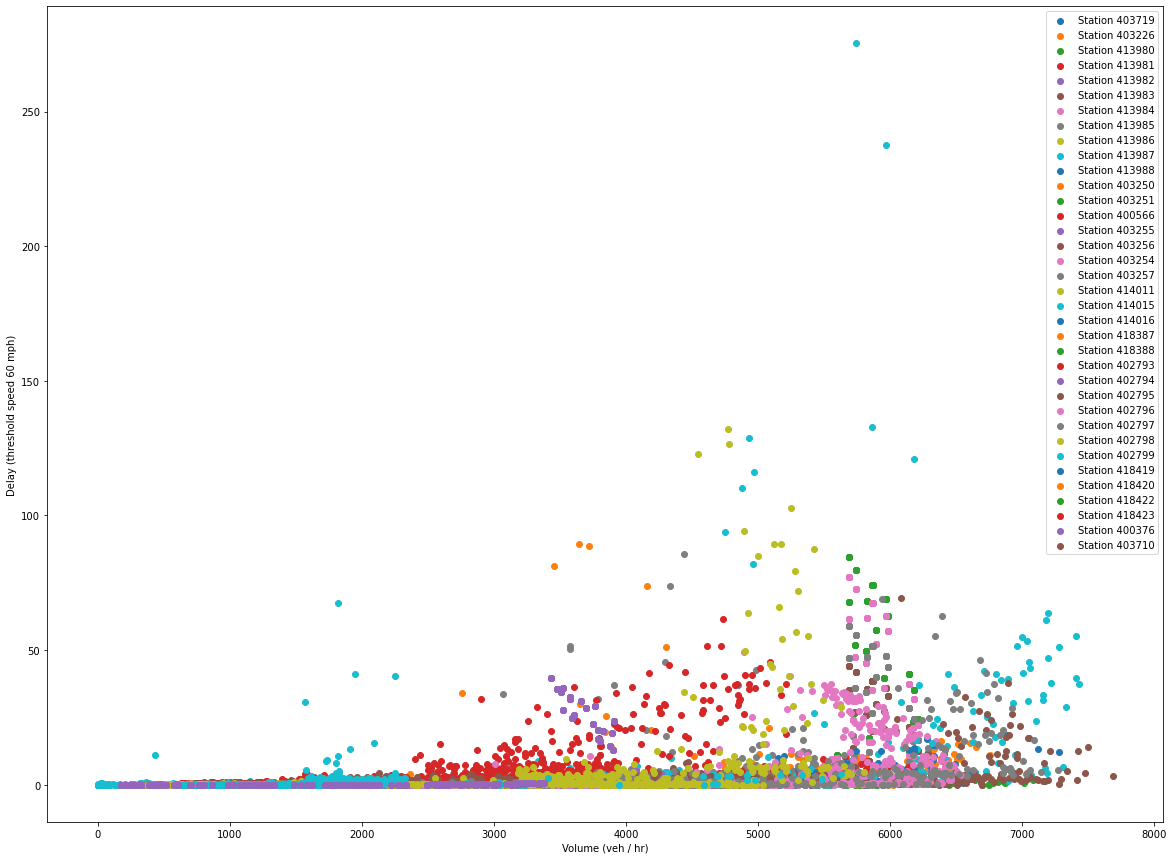

In [40]:
plot_pems_all(pems_hourly_polygon_data, 'total_flow', 'delay_60')

## To do: From OSM data create plots like the following ones (by parsing the data and converting it to shapefile):

In [ ]:
# --- Global variables

# Setting up the Coordinate Reference Systems up front in the necessary format.
crs_degree = {'init': 'epsg:4326'} # CGS_WGS_1984 (what the GPS uses)

# --- Paths

# Root path of Fremont Dropbox

# We let this notebook to know where to look for fremontdropbox module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from fremontdropbox import get_dropbox_location
# Root path of the Dropbox business account
dbx = get_dropbox_location()

# Temporary! Location of the folder where the restructuring is currently happening
data_path = dbx + '/Private Structured data collection'

def to_gdf(path):
    gdf = gpd.GeoDataFrame.from_file(path)
    gdf = gdf.to_crs('epsg:4326')
    return gdf

aimsun_path = dbx + '/Private Structured data collection/Aimsun/Inputs/'

nodes = to_gdf(aimsun_path +'nodes.shp')
sections = to_gdf(aimsun_path +'sections.shp')

fremont_map = KeplerGl(height=600)
fremont_map.add_data(data = nodes, name="nodes")
fremont_map.add_data(data = sections, name="sections")
fremont_map

In [ ]:
def to_gdf_csv(path):
# https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html#from-wkt-format
    df = pd.read_csv(path)
    gdf = gpd.GeoDataFrame(
        df, crs='epsg:4326', geometry=gpd.points_from_xy(df.x, df.y))
    return gdf

network_infra_path = data_path + "/Manual-made dataset (do not touch)/Network/Infrastructure/"

stop_signs = to_gdf_csv(network_infra_path + "Stop signs location/Stop_Signs.csv")
traffic_lights = to_gdf_csv(network_infra_path + "Traffic lights location/Traffic_Lights.csv")

fremont_map = KeplerGl(height=600)
fremont_map.add_data(data = stop_signs, name="Stop signs")
fremont_map.add_data(data = traffic_lights, name="Traffic lights")
fremont_map

In [ ]:
POIs = pd.read_csv(data_path + "/Data processing/Raw/Network/KPIs/locations_crawl.csv")
# Creating a Geographic data frame for Point of Interests
POIs_gdf = gpd.GeoDataFrame(POIs, crs=crs_degree, geometry=gpd.points_from_xy(POIs.Long, POIs.Lat))


intersections = gpd.overlay(POIs_gdf, project_del[project_del.Type == "Delimitation"], how='intersection')

map_2 = KeplerGl(height=1000)
map_2.add_data(data=intersections, name = "Points Of Interest")
map_2

## OSM Parsing


### Add download of public traces + historical network data

### Parse OSM network to check:
- if roads have speed limits, capacity, and cost functions 
- if there are traffic lights and stop signs information
- if there are points of interest
- turn restrictions
- historical data (when the road sections has been created)

### Then convert OSM to shapefile and render it with Kepler.gl

# `pip install osmnx` before running

In [ ]:
osm_graph = ox.core.graph_from_polygon(delimitation_poly)

In [ ]:
data_list = []
for u, v, key, data in osm_graph.edges(keys=True, data=True):
    data_list.append(data)
    
dl_df = pd.DataFrame(data_list)

In [ ]:
dl_df[dl_df['highway'] == 'primary']

In [ ]:
nodes, streets = ox.graph_to_gdfs(osm_graph)

fremont_map = KeplerGl(height=600)
fremont_map.add_data(data = nodes, name="Intersection Nodes")
fremont_map.add_data(data = streets, name="Road Network")
fremont_map

In [ ]:
osm_graph_full = ox.core.graph_from_polygon(delimitation_poly, simplify=False)
nodes_full, streets_full = ox.graph_to_gdfs(osm_graph_full)

In [ ]:
osm_graph_2 = ox.core.graph_from_polygon(delimitation_poly, simplify=False, infrastructure="relation")

In [ ]:
for u, v, key, data in osm_graph_2.edges(keys=True, data=True):
    data_list.append(data)
    
dl_df = pd.DataFrame(data_list)
dl_df

In [ ]:
nodes_2, streets_2 = ox.graph_to_gdfs(osm_graph_2)

In [ ]:
stop_signs = nodes_full[nodes_full['highway'] == 'stop']
traffic_signals = pd.concat([nodes_full[nodes_full['highway'] == 'traffic_signals'], nodes_2[nodes_2['highway'] == 'traffic_signals']])

fremont_map = KeplerGl(height=600)
fremont_map.add_data(data = nodes_full, name="All Nodes")
fremont_map.add_data(data = stop_signs, name="Stop Signs")
fremont_map.add_data(data = traffic_signals, name="Traffic Signals")
fremont_map

In [ ]:
osm_poi_gdf = ox.pois_from_polygon(delimitation_poly)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', None)

# osm_poi_gdf = osm_poi_gdf[osm_poi_gdf.type == 'Point'][['amenity', 'name', 'geometry']]

for idx, row in osm_poi_gdf.iterrows():
    if osm_poi_gdf.loc[idx,'geometry'].type != 'Point':
        osm_poi_gdf.loc[idx,'geometry'] = osm_poi_gdf.loc[idx,'geometry'].centroid

osm_poi_gdf = osm_poi_gdf[['amenity', 'name', 'geometry']]
osm_poi_gdf = osm_poi_gdf.dropna(subset=['name'])

osm_poi_gdf

In [ ]:
fremont_map = KeplerGl(height=600)
fremont_map.add_data(data = osm_poi_gdf, name="Points of Interest")
fremont_map

In [ ]:
## external centroids with OSM network and closer delimitation

In [ ]:
## Create the external TAZs using Google Maps API

In [ ]:
## Get google maps POIs

In [ ]:
## Get neighborhood information + other shapefile data

In [ ]:
## Do k-mean clustering to create internal centroids

In [ ]:
## Get boundaries of internal TAZs

In [ ]:
## Create TAZs

In [ ]:
## Create centroid connections

In [ ]:
## Create files for Aimsun with centroid connections and centroid and OSM network

See [Aimsun documentation to create the layers](https://www.aimsun.com/tech_notes/gis-import-1/)

In [ ]:
## Download Google Maps tiles corresponding to the project